# NDVI

Create an NDVI image and histogram using a [PlanetScope 4-band image](https://developers.planet.com/docs/data/psscene4band/) (PSScene4Band)

A Planet API key is required

In [1]:
import sys
sys.path.append('../')
import rasterio
import numpy as np

# FIXME: Remove this block after module code has been completed
%load_ext autoreload
%autoreload 1
%aimport rstools.main

from rstools.main import midpoint_normalize, show_ndvi_fig, show_ndvi_hist, get_reflectance_coeffs, get_bands

## Specify input data and output folders

In [2]:
DATA_LOC = '../data/'
OUTPUT_LOC = '../output/'

## Band Order for PlanetScope 4-band images (PSScene4Band)

In [3]:
ANALYTIC_BAND_NUMS=dict(BLUE = 1, GREEN = 2, RED = 3, NIR = 4)

## Specify Planet item id for PSScene4Band image

In [4]:
#PLANET_ITEM_ID = '20160831_180302_0e26' #reflectance coeffs 2.55957020415e-05 3.87396124832e-05
                                        #range NDVI (-0.999551583679821, 0.9998732042084099)

#PLANET_ITEM_ID = '20210217_173811_1026'#reflectance coeffs (3.09419250778e-05, 4.68637435774e-05)
                                        #range NDVI (-0.6696521855564906, 0.5279276908614214)

# SANTA FE OPEN SPACE 2020-07-04
#PLANET_ITEM_ID = '20200704_173510_95_1062'#reflectance coeffs (2.36459796684e-05, 3.68854257857e-05)
                                        #range NDVI (-0.11468907042978817, 0.6800783024111237)
    
# Rice Terrace Clusters of Mayoyao: Mayoyao Central
#PLANET_ITEM_ID = '20210202_020545_101f'
#PLANET_ITEM_ID = '20201119_024057_71_1066'
PLANET_ITEM_ID = '20200601_024315_01_1065' #Superdove
    
# TEST DATA FROM ORIGINAL NOTEBOOK
#PLANET_ITEM_ID = '20210217_173809_1026' #reflectance coeffs 3.10115984374e-05 4.696926883e-05
                                        #range NDVI (-0.6923316699660859, 0.6292593054291127)

    

## Download image and metadata from Planet

In [5]:
!planet data download --item-type PSScene4Band --dest $DATA_LOC --asset-type analytic_sr --string-in id $PLANET_ITEM_ID

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 1               paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 1           elapsed: 2               paging: False                 
pending: 0                                                                      

{"item": "20200601_024315_01_1065", "asset": "analytic_sr", "location": "/home/jovyan/work/data/20200601_024315_01_1065_3B_AnalyticMS_SR.tif"}


## Specify input and output files

In [6]:
# Input
filename_img = DATA_LOC + PLANET_ITEM_ID + '_3B_AnalyticMS_SR.tif'

# Output
filename_ndvi = OUTPUT_LOC + PLANET_ITEM_ID + '_ndvi.tif'
filename_ndvi_fig = OUTPUT_LOC + PLANET_ITEM_ID + '_ndvi-fig.png'
filename_ndvi_hist = OUTPUT_LOC + PLANET_ITEM_ID + '_ndvi-histogram.png'

## Read the Red and NIR bands

In [7]:
bands, metadata = get_bands(filename_img, ANALYTIC_BAND_NUMS)

## Calculate NDVI

In [8]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (bands['NIR'].astype(float) - bands['RED'].astype(float)) / (bands['NIR'] + bands['RED'])

## Review the min and max NDVI values

In [9]:
np.nanmin(ndvi), np.nanmax(ndvi)

(-0.9996232812205689, 0.9148753224419605)

## Save a single band NDVI file

In [10]:
# Read metadata from original image
kwargs = metadata

# Update metadata for NDVI: a single band of float32 values
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write to NDVI file
with rasterio.open(filename_ndvi, 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))
        
# TODO: Color Map

## NDVI with Color Map and Color Bar 
Set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/

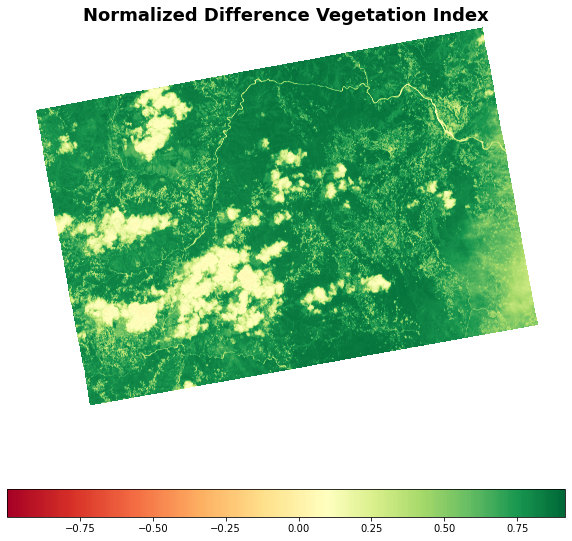

In [11]:
show_ndvi_fig(ndvi, filename_ndvi_fig, midpoint=0.1, figsize=(20, 10))

## NDVI Histogram

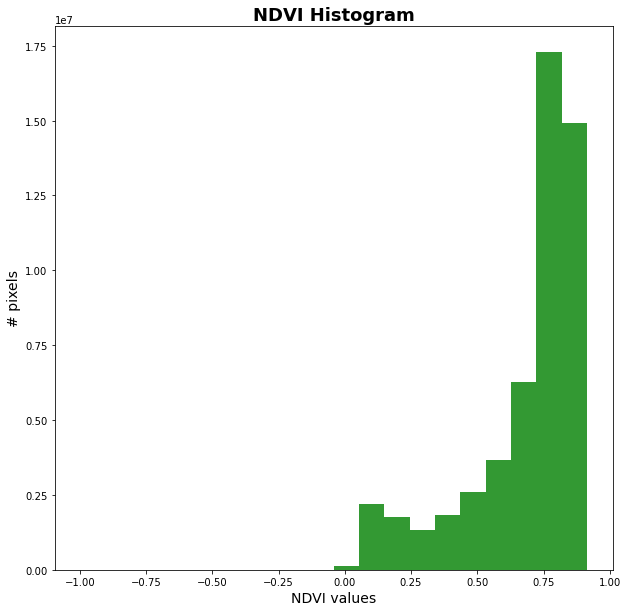

In [12]:
show_ndvi_hist(ndvi, filename_ndvi_hist, figsize=(10, 10))